In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [2]:
# %pip install split-folders


In [3]:
# import splitfolders
# data_dir = './Driver Drowsiness Dataset (DDD)'
# output_dir = './Driver Drowsiness Dataset (DDD)/splitted_Data'
# splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

In [4]:
# splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

In [5]:
train_dir = "./Driver Drowsiness Dataset (DDD)/splitted_Data/train"
test_dir = "./Driver Drowsiness Dataset (DDD)/splitted_Data/test"
val_dir = "./Driver Drowsiness Dataset (DDD)/splitted_Data/val"

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


Pixels of the first image after Normalization: 

[[[0.8745099  0.8745099  0.8313726 ]
  [0.8745099  0.8745099  0.83921576]
  [0.882353   0.8745099  0.83921576]
  ...
  [0.7803922  0.7725491  0.74509805]
  [1.         1.         1.        ]
  [0.59607846 0.59607846 0.56078434]]

 [[0.8862746  0.87843144 0.8431373 ]
  [0.882353   0.8745099  0.83921576]
  [0.882353   0.8745099  0.83921576]
  ...
  [1.         1.         1.        ]
  [0.8313726  0.8313726  0.7960785 ]
  [0.3921569  0.3921569  0.3529412 ]]

 [[0.882353   0.8745099  0.8431373 ]
  [0.882353   0.8745099  0.8431373 ]
  [0.882353   0.8745099  0.83921576]
  ...
  [0.9294118  0.9294118  0.9215687 ]
  [0.39607847 0.38431376 0.34901962]
  [0.9803922  0.9803922  0.9686275 ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.26666668 0.27450982 0.2784314 ]
  [0.5058824  0.5137255  0.5176471 ]
  [0.94117653 0.94117653 0.9450981 ]]

 [[1.         1.         

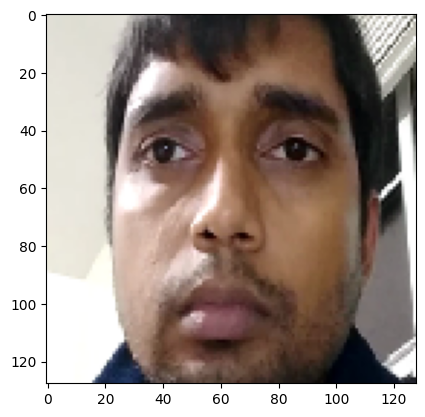

In [8]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[3]}")
plt.imshow(images[3])
plt.show()

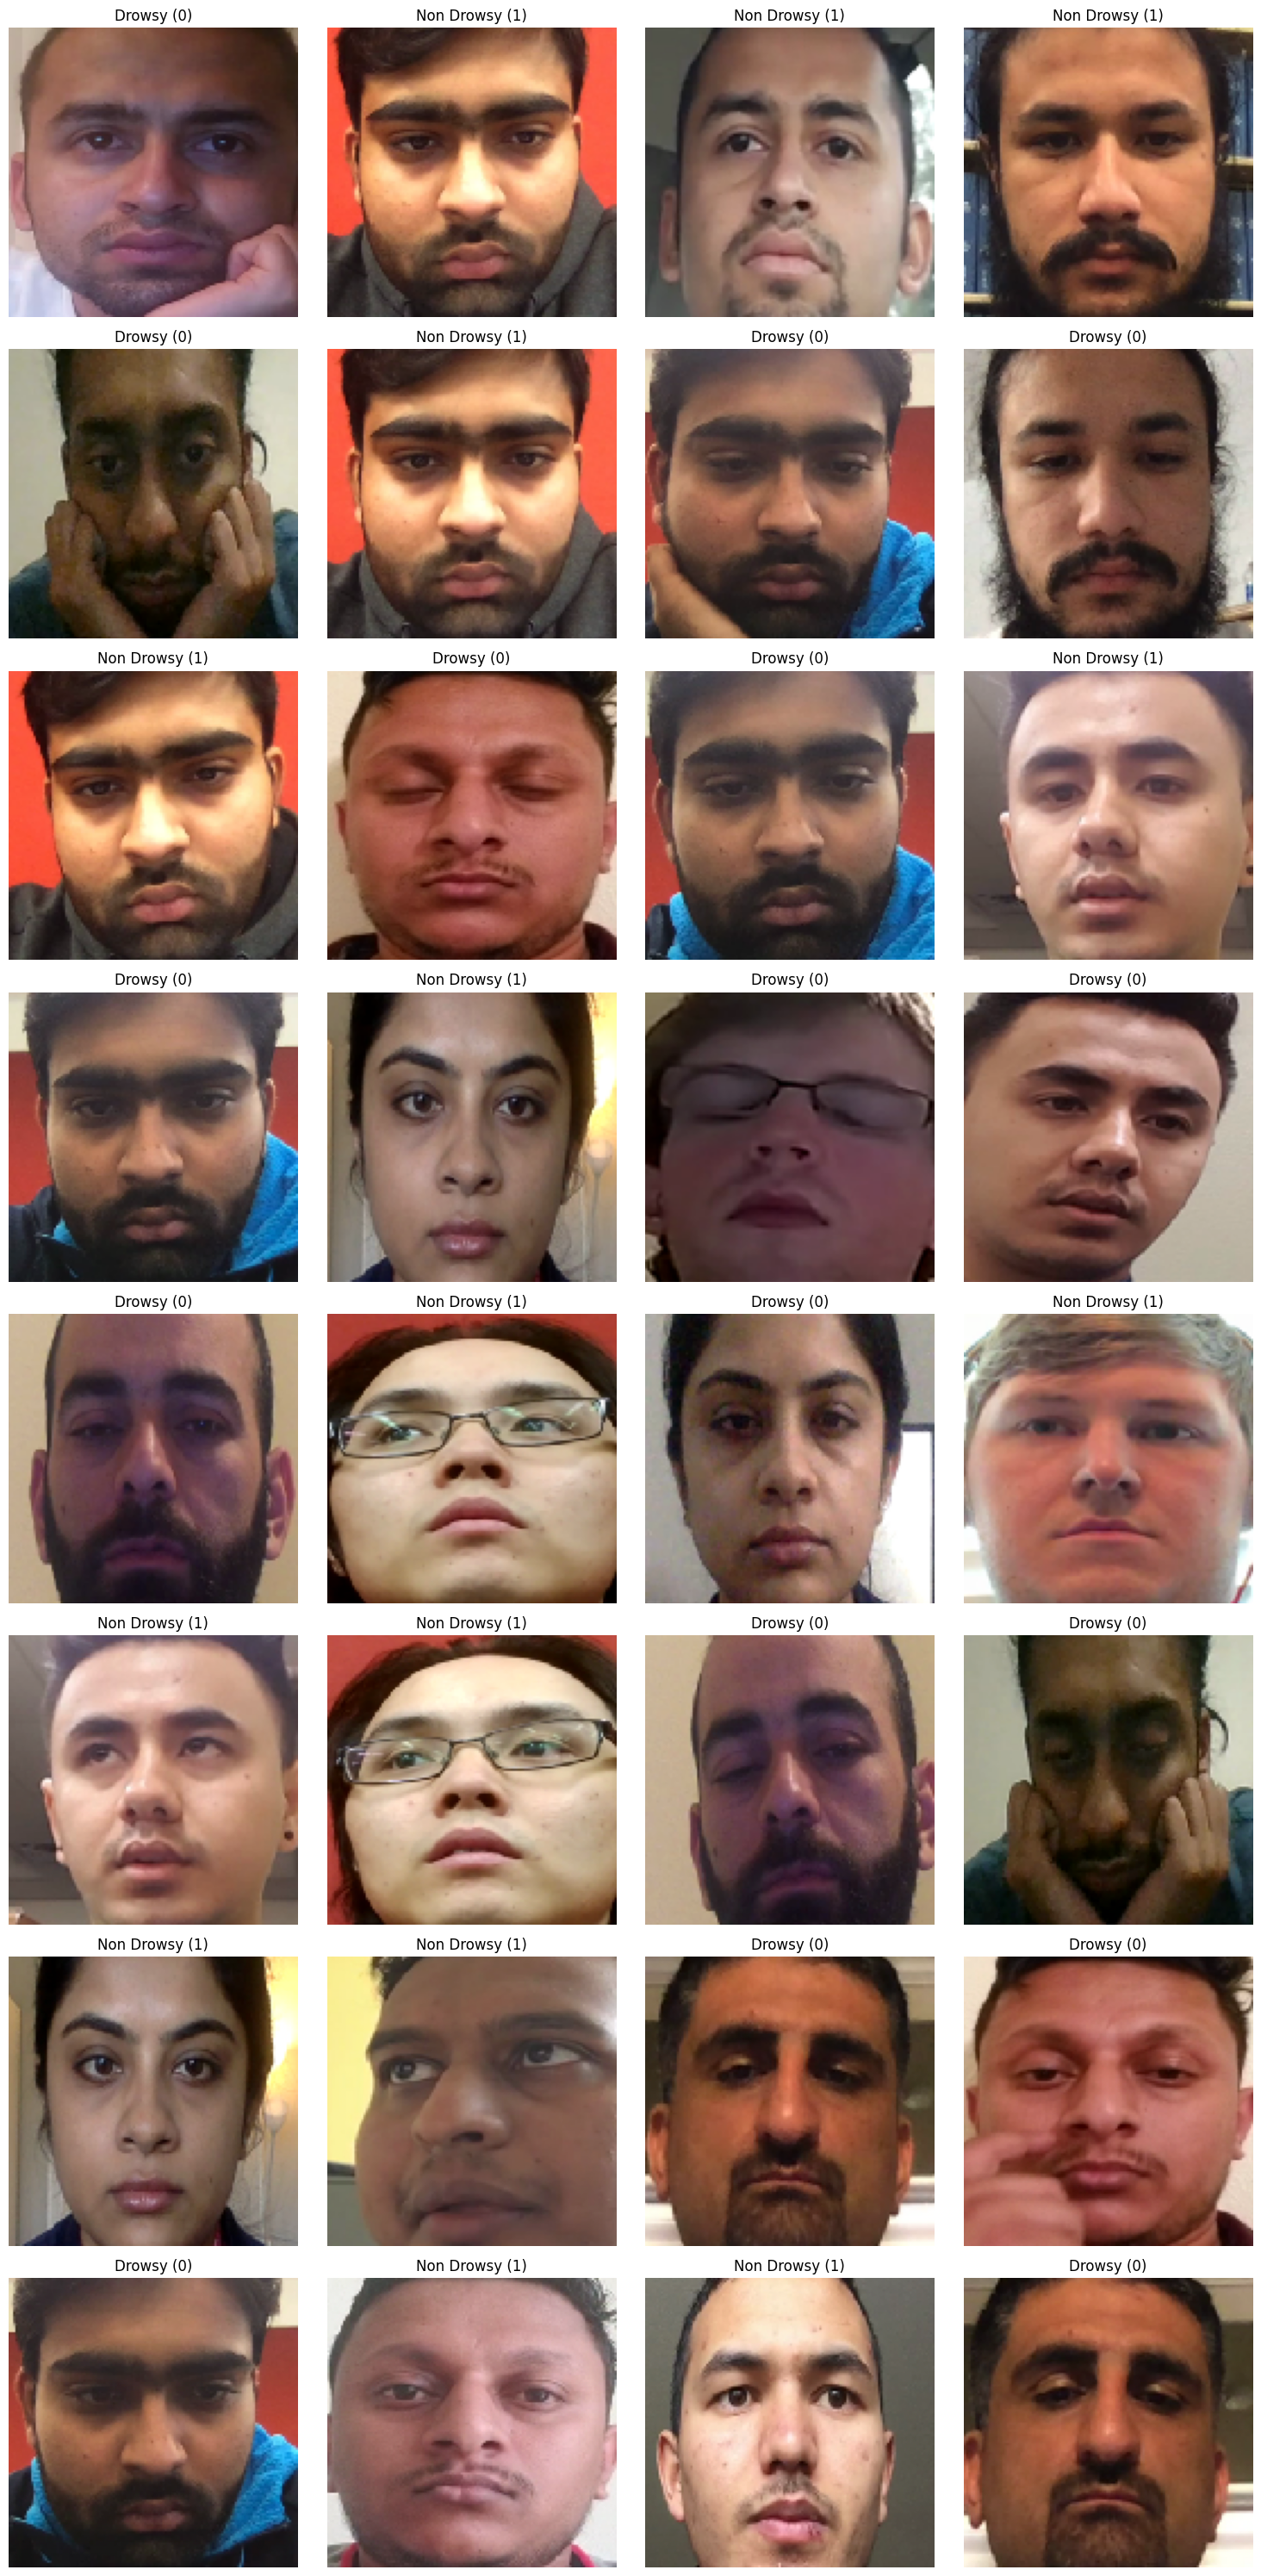

In [9]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):
        
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])  
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [10]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),  
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),  
    LSTM(16, return_sequences=False),  
    Dropout(0.3),

    Dense(8, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 128, 128, 8)    224       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 128, 128, 8)    32        
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 64, 64, 8)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 64, 64, 16)     1168      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 64, 64, 16)     6

In [11]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []
        
        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)
        
        return np.array(X_seq), np.array(y_seq)

In [12]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [13]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=20
)

Epoch 1/20
65/65 [==============================] - 839s 13s/step - loss: 0.6875 - accuracy: 0.5468 - val_loss: 0.6923 - val_accuracy: 0.5368
Epoch 2/20
65/65 [==============================] - 709s 11s/step - loss: 0.6721 - accuracy: 0.5790 - val_loss: 0.6912 - val_accuracy: 0.5340
Epoch 3/20
65/65 [==============================] - 648s 10s/step - loss: 0.6568 - accuracy: 0.6053 - val_loss: 0.6896 - val_accuracy: 0.5350
Epoch 4/20
65/65 [==============================] - 763s 12s/step - loss: 0.6353 - accuracy: 0.6396 - val_loss: 0.6856 - val_accuracy: 0.5742
Epoch 5/20
65/65 [==============================] - 768s 12s/step - loss: 0.6131 - accuracy: 0.6682 - val_loss: 0.6794 - val_accuracy: 0.5699
Epoch 6/20
65/65 [==============================] - 802s 12s/step - loss: 0.5899 - accuracy: 0.6932 - val_loss: 0.6916 - val_accuracy: 0.5190
Epoch 7/20
65/65 [==============================] - 849s 13s/step - loss: 0.5614 - accuracy: 0.7244 - val_loss: 0.6756 - val_accuracy: 0.5496
Epoch 

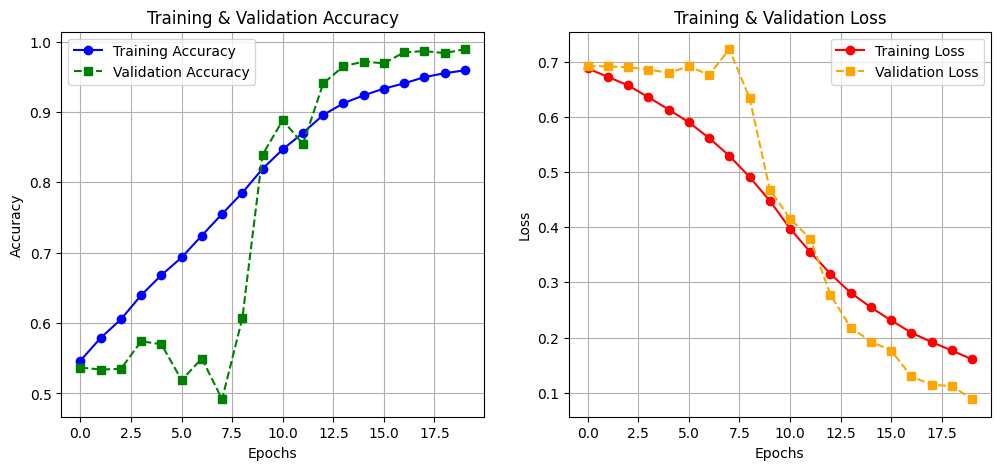

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", color="blue", marker="o", linestyle="-")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="green", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color="red", marker="o", linestyle="-")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True)

plt.show()

# Save model

In [ ]:
model.save("ddd_cnnlstm.h5")
model.save('ddd_cnnlstm')

# Convert to TensorFlow Lite

In [2]:
import tensorflow as tf

# Load lại mô hình Keras
model = tf.keras.models.load_model('./saved_models/ddd_cnnlstm.h5')

# Chuyển sang TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Cho phép sử dụng toán tử ngoài TFLite (TF Select Ops)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Tắt hạ tầng TensorList
converter._experimental_lower_tensor_list_ops = False

# Tiến hành chuyển đổi
tflite_model = converter.convert()

# Lưu lại
with open('./saved_models/ddd_cnnlstm.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmplc8lmuds\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmplc8lmuds\assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_models/ddd_cnnlstm')  # Thư mục chứa SavedModel
tflite_model = converter.convert()

with open('./saved_models/ddd_cnnlstm.tflite', 'wb') as f:
    f.write(tflite_model)
